In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")



CUDA Available: True
Device Name: Tesla T4


In [ ]:
!git clone https://github.com/brysef/rfml.git
%cd rfml
!pip install -e .
!pip install scikit-learn matplotlib
%cd ..


Cloning into 'rfml'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 260 (delta 8), reused 4 (delta 4), pack-reused 238 (from 2)
Receiving objects: 100% (260/260), 17.47 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/rfml
Obtaining file:///content/rfml
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 10.2 MB/s eta 0:00:00
  Created wheel for setGPU: filename=setGPU-0.0.7-py3-none-any.whl size=1520 sha256=a48f9ee8ae367c96bb3a1f3e7b14b82cd76380d443bd9e37e08f1a258f106e31
  Stored in directory: /root/.cache/pip/wheels/52/79/6d/96734c88393595b27892f601ac5415c3422bc3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change this path to where your file is in Drive
import pickle

dataset_path = "/content/drive/MyDrive/RF_dataset/RML2016.10a_dict.pkl"

with open(dataset_path, "rb") as f:
    Xd = pickle.load(f, encoding="latin1")

print("Dataset keys:", list(Xd.keys())[:10])


Dataset keys: [('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2)]


In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# ------------------------------
# 0️⃣ Define digital modulations
# ------------------------------
digital_mods = ['BPSK', 'QPSK', '8PSK', 'QAM16', 'QAM64', 'PAM4', 'CPFSK', 'GFSK']

# ------------------------------
# 1️⃣ Build dataset and align SNRs
# ------------------------------
X_all, Y_all, snrs_all = [], [], []

for mod, snr in Xd.keys():
    if mod not in digital_mods:
        continue
    samples = Xd[(mod, snr)]
    for s in samples:
        X_all.append(s)
        Y_all.append(digital_mods.index(mod))
        snrs_all.append(snr)

X_all = np.array(X_all)
Y_all = np.array(Y_all)
snrs_all = np.array(snrs_all)

# Normalize I-Q values
X_all = (X_all - np.mean(X_all, axis=-1, keepdims=True)) / \
        (np.std(X_all, axis=-1, keepdims=True) + 1e-6)

print("Final dataset shape:", X_all.shape, Y_all.shape)
print("Unique classes:", np.unique(Y_all))

Final dataset shape: (160000, 2, 128) (160000,)
Unique classes: [0 1 2 3 4 5 6 7]


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
Y_all = label_encoder.fit_transform(Y_all)

# ------------------------------
# 2️⃣ Train/Val/Test split (67/13/20) with SNR alignment
# ------------------------------
X_train, X_temp, Y_train, Y_temp, snrs_train, snrs_temp = train_test_split(
    X_all, Y_all, snrs_all, test_size=0.33, random_state=42, stratify=Y_all
)

val_ratio = 13 / (13 + 20)  # 13% of total for val
X_val, X_test, Y_val, Y_test, snrs_val, snrs_test = train_test_split(
    X_temp, Y_temp, snrs_temp, test_size=(1 - val_ratio), random_state=42, stratify=Y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ------------------------------
# 3️⃣ PyTorch Dataset wrapper
# ------------------------------
class RadioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

batch_size = 1024
train_loader = DataLoader(RadioDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(RadioDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(RadioDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

# ------------------------------
# Reusable training / eval utilities + multi-layer experiment
# ------------------------------
import copy
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Modify LSTMClassifier to accept variable dropout and hidden_size if you want
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2, num_classes=len(label_encoder.classes_)):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.3 if num_layers>1 else 0.0,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        out, _ = self.lstm(x)
        out = out[:, -1, :]     # take last timestep
        out = self.fc(out)
        return out






Train: (107200, 2, 128) Val: (20800, 2, 128) Test: (32000, 2, 128)


In [ ]:
# training function that accepts model and returns trained model (keeps local optimizer)
def train_model_variant(model, train_loader, val_loader, device, epochs=30, lr=3e-4, verbose=True):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == Y_batch).sum().item()
            running_total += X_batch.size(0)

        train_acc = running_correct / running_total

        # validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == Y_batch).sum().item()
                val_total += X_batch.size(0)
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        if verbose and ((epoch+1) % 5 == 0 or epoch==0 or epoch==epochs-1):
            print(f"[Layers={model.lstm.num_layers}] Epoch {epoch+1}/{epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    # load best weights
    model.load_state_dict(best_model_wts)
    return model, best_val_acc

# evaluate per-snr (reuse your evaluate_snr earlier but make it accept model object)
def evaluate_snr_model(model, X_test, Y_test, snrs_test, snr_list, device, batch_size=1024):
    model = model.to(device)
    model.eval()
    snr_accs = {}
    with torch.no_grad():
        for snr in snr_list:
            mask = (snrs_test == snr)
            if mask.sum() == 0:
                snr_accs[snr] = np.nan  # no samples for this snr in test split
                continue
            X = torch.tensor(X_test[mask], dtype=torch.float32).to(device)
            Y = torch.tensor(Y_test[mask], dtype=torch.long).to(device)
            dataset = torch.utils.data.TensorDataset(X, Y)
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
            all_preds = []
            all_labels = []
            for xb, yb in loader:
                out = model(xb)
                _, pred = torch.max(out, 1)
                all_preds.append(pred.cpu().numpy())
                all_labels.append(yb.cpu().numpy())
            all_preds = np.concatenate(all_preds)
            all_labels = np.concatenate(all_labels)
            acc = accuracy_score(all_labels, all_preds)
            snr_accs[snr] = acc
    return snr_accs

In [ ]:
# ------------------------------
# Run experiments for num_layers = [1,2,3]
# ------------------------------
snr_list = list(range(-20, 19, 2))  # -20..18 step 2
layer_options = [1, 2, 3]
epochs = 30          # adjust if you want faster / slower
results = {}         # will be {layers: {snr: acc, ...}, ...}
val_scores = {}

for nl in layer_options:
    print("\n" + "="*60)
    print(f"Training LSTM with {nl} layer(s)")
    set_seed(42)  # reset seed so train/val splits & weight init are consistent
    model_variant = LSTMClassifier(input_size=2, hidden_size=128, num_layers=nl, num_classes=len(label_encoder.classes_))
    trained_model, best_val = train_model_variant(model_variant, train_loader, val_loader, device, epochs=epochs, lr=3e-4, verbose=True)
    print(f"Best validation acc for {nl} layers: {best_val*100:.2f}%")
    val_scores[nl] = best_val

    # Evaluate per-SNR on test set
    snr_accs = evaluate_snr_model(trained_model, X_test, Y_test, snrs_test, snr_list, device, batch_size=batch_size)
    results[nl] = snr_accs


# You can also save df.to_csv("snr_accuracy_by_layers.csv")


Training LSTM with 1 layer(s)
[Layers=1] Epoch 1/30 | Train Acc: 13.18% | Val Acc: 14.53%
[Layers=1] Epoch 5/30 | Train Acc: 23.80% | Val Acc: 24.68%
[Layers=1] Epoch 10/30 | Train Acc: 25.15% | Val Acc: 25.44%
[Layers=1] Epoch 15/30 | Train Acc: 30.37% | Val Acc: 30.87%
[Layers=1] Epoch 20/30 | Train Acc: 33.64% | Val Acc: 33.11%
[Layers=1] Epoch 25/30 | Train Acc: 36.30% | Val Acc: 36.61%
[Layers=1] Epoch 30/30 | Train Acc: 35.80% | Val Acc: 36.57%
Best validation acc for 1 layers: 36.87%

Training LSTM with 2 layer(s)
[Layers=2] Epoch 1/30 | Train Acc: 13.63% | Val Acc: 18.79%
[Layers=2] Epoch 5/30 | Train Acc: 25.23% | Val Acc: 20.68%
[Layers=2] Epoch 10/30 | Train Acc: 36.54% | Val Acc: 37.05%
[Layers=2] Epoch 15/30 | Train Acc: 39.69% | Val Acc: 41.61%
[Layers=2] Epoch 20/30 | Train Acc: 49.33% | Val Acc: 49.12%
[Layers=2] Epoch 25/30 | Train Acc: 51.44% | Val Acc: 50.79%
[Layers=2] Epoch 30/30 | Train Acc: 52.55% | Val Acc: 52.46%
Best validation acc for 2 layers: 52.46%

Train

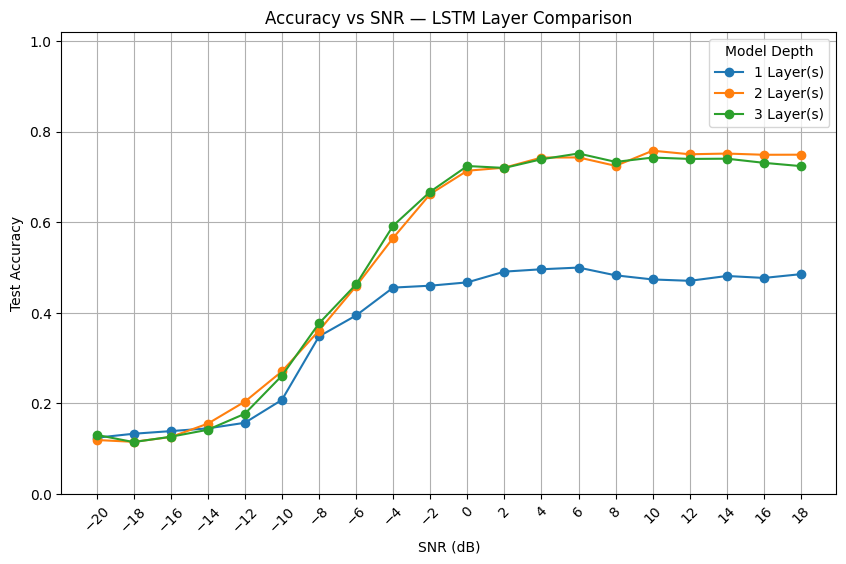

,1 Layer(s),2 Layer(s),3 Layer(s)
SNR (dB),,,
-20,0.124369,0.119318,0.130682
-18,0.133129,0.115337,0.114724
-16,0.138941,0.125857,0.126480
-14,0.144954,0.155352,0.141896
-12,0.157338,0.203980,0.177239
-10,0.207883,0.270820,0.261284
-8,0.348012,0.360856,0.376758
-6,0.394256,0.458877,0.462794
-4,0.455799,0.565517,0.592476


In [ ]:
# ------------------------------
# Plot combined SNR curves (Accuracy comparison only)
# ------------------------------
plt.figure(figsize=(10,6))
for nl in layer_options:
    accs = [results[nl].get(s, np.nan) for s in snr_list]
    plt.plot(snr_list, accs, marker='o', label=f"{nl} Layer(s)")

plt.xlabel("SNR (dB)")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs SNR — LSTM Layer Comparison")
plt.xticks(snr_list, rotation=45)
plt.ylim(0, 1.02)
plt.grid(True)
plt.legend(title="Model Depth")
plt.show()

# ------------------------------
# Summary table for inspection
# ------------------------------
import pandas as pd

df = pd.DataFrame(
    {f"{nl} Layer(s)": [results[nl].get(s, np.nan) for s in snr_list] for nl in layer_options},
    index=snr_list
)
df.index.name = "SNR (dB)"

display(df)


Low SNR Accuracy: 0.1441, Samples: 8062
Medium SNR Accuracy: 0.5628, Samples: 12793
High SNR Accuracy: 0.7344, Samples: 11145


<Figure size 800x800 with 0 Axes>

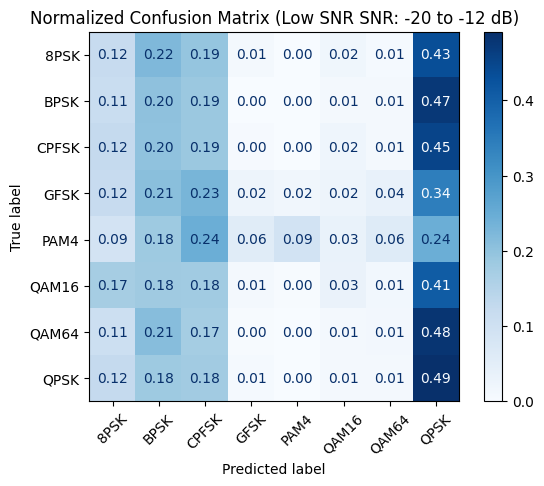

<Figure size 800x800 with 0 Axes>

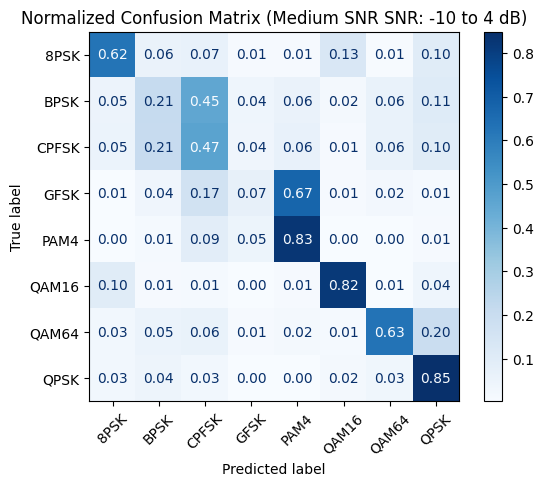

<Figure size 800x800 with 0 Axes>

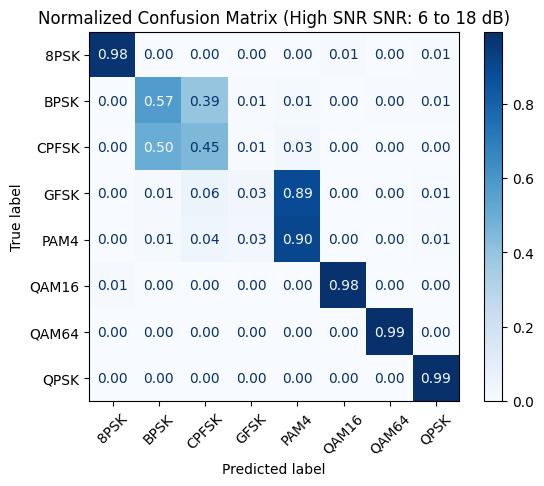

In [ ]:
# ------------------------------
# 7️⃣ Evaluate & Plot per SNR
# ------------------------------
def evaluate_snr(model, X_test, Y_test, snrs_test, snr_range, batch_size=1024):
    mask = np.isin(snrs_test, snr_range)
    X = torch.tensor(X_test[mask], dtype=torch.float32).to(device)
    Y = torch.tensor(Y_test[mask], dtype=torch.long).to(device)
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb)
            _, pred = torch.max(out, 1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm, all_labels

# Define SNR ranges
snr_ranges = {
    "Low SNR": list(range(-20, -10, 2)),     # -20, -18, ... -12
    "Medium SNR": list(range(-10, 6, 2)),    # -10, -8, ... 4
    "High SNR": list(range(6, 20, 2))        # 6, 8, ... 18
}

acc_vs_snr = {}
cms = {}

for label, snr_range in snr_ranges.items():
    acc, cm, labels = evaluate_snr(model, X_test, Y_test, snrs_test, snr_range)
    acc_vs_snr[label] = acc
    cms[label] = cm
    print(f"{label} Accuracy: {acc:.4f}, Samples: {len(labels)}")

# # ------------------------------
# # 8️⃣ Plot Accuracy per SNR Range
# # ------------------------------
# plt.figure(figsize=(7,5))
# plt.bar(acc_vs_snr.keys(), [v*100 for v in acc_vs_snr.values()], color=['red','orange','green'])
# plt.ylabel("Accuracy (%)")
# plt.title("Classification Accuracy per SNR Range")
# plt.ylim(0,100)
# plt.grid(axis='y')
# plt.show()
# ------------------------------
# 9️⃣ Plot Confusion Matrices
# ------------------------------
mods = sorted(list(set([mod for (mod, snr) in Xd.keys() if mod in digital_mods])))

for label, snr_range in snr_ranges.items():
    cm = cms[label]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=mods)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format=".2f")
    plt.title(f"Normalized Confusion Matrix ({label} SNR: {min(snr_range)} to {max(snr_range)} dB)")
    plt.show()
